In [24]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, confusion_matrix
import xgboost as xgb
import lightgbm as lgb
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import numpy as np

In [3]:
df = pd.read_csv(r"C:\Users\alefs\OneDrive\Documentos\LAPEI-CIGETS\GitHub\tcp\01_dados\data_mobilidade_v4.csv")

list(df)

['Unnamed: 0',
 'id',
 'id_seq',
 'transicao',
 'V1023',
 'idade',
 'genero',
 'VD3004',
 'V2010',
 'V2005',
 'UF',
 'qtd_pessoas',
 'periodo_ajust',
 'ensino_medio',
 'ensino_superior',
 'raça',
 'posicao_familiar',
 'tempo_desemprego',
 'filhos',
 'regiao',
 'renda_domiciliar',
 'renda_depois']

In [107]:
df_tratado = df.rename(columns={'V1023':'regiao_urbana','VD3004':'escolaridade','V2010':'cor','UF':'uf'})

df_tratado = df_tratado[['transicao','idade','escolaridade', 'genero', 'cor','qtd_pessoas',
                         'periodo_ajust','filhos', 'tempo_desemprego', 'uf',
                        'posicao_familiar', 'renda_domiciliar', 'regiao_urbana']]

bins = [0, 3, 5, 9, 21, float('inf')]
labels = ['Tempo de desemprego: muito baixo', 'Tempo de desemprego: baixo', 
          'Tempo de desemprego: mediano', 'Tempo de desemprego: alto', 'Tempo de desemprego: muito alto']
df_tratado['intervalo_desemprego'] = pd.cut(df_tratado['tempo_desemprego'], bins=bins, labels=labels, right=False)

df_tratado['transicao'] = df_tratado['transicao'].map({'Migrou para TCP': 1, 'Migrou para o setor privado': 0})

df_final = df_tratado.drop(columns = 'tempo_desemprego')

df_final.head(30).style

,transicao,idade,escolaridade,genero,cor,qtd_pessoas,periodo_ajust,filhos,uf,posicao_familiar,renda_domiciliar,regiao_urbana,intervalo_desemprego
0,1,28,Superior completo,Homem,Parda,3.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,750.000000,Capital,Tempo de desemprego: mediano
1,1,33,Médio completo ou equivalente,Homem,Parda,4.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,162.500000,Capital,Tempo de desemprego: muito alto
2,1,24,Médio incompleto ou equivalente,Mulher,Parda,2.000000,Pré-pandemia,0,Rondônia,Não responsável pelo domicílio,488.500000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: muito alto
3,0,39,Superior completo,Homem,Parda,4.000000,Pré-pandemia,1,Rondônia,Responsável pelo domicílio,378.750000,"Resto da UF (Unidade da Federação, excluindo a região metropolitana e a RIDE)",Tempo de desemprego: baixo
4,0,26,Superior completo,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Não responsável pelo domicílio,418.000000,Capital,Tempo de desemprego: baixo
5,0,49,Fundamental incompleto ou equivalente,Mulher,Parda,3.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,53.333333,Capital,Tempo de desemprego: mediano
6,0,34,Fundamental completo ou equivalente,Homem,Parda,1.000000,Pré-pandemia,0,Acre,Responsável pelo domicílio,0.000000,Capital,Tempo de desemprego: muito baixo
7,0,42,Sem instrução e menos de 1 ano de estudo,Homem,Branca,3.000000,Pré-pandemia,1,Acre,Não responsável pelo domicílio,318.000000,Capital,Tempo de desemprego: alto
8,0,22,Médio completo ou equivalente,Homem,Parda,6.800000,Pré-pandemia,0,Amazonas,Não responsável pelo domicílio,25.714286,Capital,Tempo de desemprego: alto
9,0,48,Médio completo ou equivalente,Homem,Parda,8.800000,Pré-pandemia,0,Amazonas,Responsável pelo domicílio,408.555556,Capital,Tempo de desemprego: mediano


In [108]:
def dividir(df):
    y = df[['transicao']]
    X = df.drop(columns=['transicao'])

    num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

    num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
    ])

    preprocessor = ColumnTransformer([
        ('num', num_pipeline, num_features),
        ('cat', cat_pipeline, cat_features)
    ])

    # Divisão dos dados em treino e teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=22)

    # Aplicar pré-processamento
    X_train_processed = preprocessor.fit_transform(X_train)
    X_test_processed = preprocessor.transform(X_test)

    # Aplicar balanceamento com SMOTE
    smote = SMOTE(random_state=5222)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

    return X_train_balanced, X_test_processed, y_train_balanced, y_test, preprocessor, X_train

In [109]:
x_train, x_test, y_train, y_test, preprocessor, x_train_raw1 = dividir(df_final)

In [95]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    'LightGBM': lgb.LGBMClassifier(random_state=42)
}

# --- Função Objetivo para o Optuna com Validação Cruzada (ATUALIZADA) ---
def objective(trial, model_name, x_train, y_train):
    """
    Função objetivo que o Optuna tentará maximizar.
    Usa validação cruzada para avaliar o desempenho de uma dada combinação de hiperparâmetros.
    """
    # Definindo os hiperparâmetros a serem otimizados
    if model_name == 'Logistic Regression':
        C = trial.suggest_float('C', 1e-2, 10, log=True)
        model = LogisticRegression(C=C, random_state=42, solver='liblinear')

    elif model_name == 'Decision Tree':
        max_depth = trial.suggest_int('max_depth', 3, 15)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
        model = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'Random Forest':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 5, 20)
        min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
        min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
        model = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)

    elif model_name == 'XGBoost':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        max_depth = trial.suggest_int('max_depth', 3, 9)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        subsample = trial.suggest_float('subsample', 0.6, 1.0)
        colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
        gamma = trial.suggest_float('gamma', 0, 1.0)
        model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, subsample=subsample, colsample_bytree=colsample_bytree, gamma=gamma, use_label_encoder=False, eval_metric='logloss', random_state=42)

    elif model_name == 'LightGBM':
        n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
        learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
        num_leaves = trial.suggest_int('num_leaves', 20, 100)
        min_child_samples = trial.suggest_int('min_child_samples', 5, 50)
        model = lgb.LGBMClassifier(n_estimators=n_estimators, learning_rate=learning_rate, num_leaves=num_leaves, min_child_samples=min_child_samples, random_state=42)

    # **AQUI ESTÁ A MUDANÇA PRINCIPAL**
    # Usando validação cruzada com 5 folds para avaliar o modelo
    # A métrica é 'roc_auc'
    score = cross_val_score(model, x_train, y_train, cv=5, scoring='roc_auc', n_jobs=-1)

    # Retorna a média das pontuações dos folds
    return score.mean()

# --- Função Principal de Treinamento e Avaliação (ATUALIZADA) ---
def treinando_avaliando_optuna(x_train, y_train, x_test, y_test):
    """
    Orquestra a otimização com Optuna e a avaliação final.
    """
    best_models = {}

    for name in models.keys():
        print(f"Otimizando o modelo: {name}")

        # Função lambda para passar os argumentos extras para a função objective
        func = lambda trial: objective(trial, name, x_train, y_train)

        # Otimização dos hiperparâmetros com Optuna
        study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
        study.optimize(func, n_trials=20) # Aumentei para 50 trials para uma busca melhor

        print(f"Melhores parâmetros para {name}: {study.best_params}\n")

        # **MUDANÇA AQUI**: Cria e treina o modelo final com os melhores parâmetros encontrados
        # no conjunto de treino COMPLETO.
        best_model_class = models[name].__class__
        best_model = best_model_class(**study.best_params, random_state=42)
        
        # Ajustes especiais para modelos que não aceitam todos os parâmetros no construtor
        if name in ['XGBoost']:
            best_model = xgb.XGBClassifier(**study.best_params, use_label_encoder=False, eval_metric='logloss', random_state=42)
        
        best_model.fit(x_train, y_train)
        best_models[name] = best_model

    # Avaliação no conjunto de teste
    results = []
    for name, model in best_models.items():
        y_pred = model.predict(x_test)
        y_prob = model.predict_proba(x_test)[:, 1]
        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'F1 Score': f1_score(y_test, y_pred),
            'ROC AUC': roc_auc_score(y_test, y_prob)
        })

    return results, best_models

In [111]:
results_df, final_models = treinando_avaliando_optuna(x_train, y_train, x_test, y_test)
results_m1_df = pd.DataFrame(results_df)
print(results_m1_df.sort_values(by = 'ROC AUC', ascending = False))

[I 2025-06-18 16:00:13,958] A new study created in memory with name: no-name-34a8c1d6-b14d-45ac-a562-c9de169ecc6d
C:\Users\alefs\AppData\Local\Temp\ipykernel_4996\3865698212.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-06-18 16:00:13,984] Trial 0 finished with value: 0.7228715862061366 and parameters: {'C': 0.13292918943162169}. Best is trial 0 with value: 0.7228715862061366.
C:\Users\alefs\AppData\Local\Temp\ipykernel_4996\3865698212.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. Th

Treinando modelo com Optuna: Logistic Regression


C:\Users\alefs\AppData\Local\Temp\ipykernel_4996\3865698212.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  C = trial.suggest_loguniform('C', 0.01, 10)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
[I 2025-06-18 16:00:14,157] Trial 6 finished with value: 0.7155465200551546 and parameters: {'C': 0.014936568554617643}. Best is trial 1 with value: 0.7265035668689637.
C:\Users\alefs\AppData\Local\Temp\ipykernel_4996\3865698212.py:13: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float

Melhores parâmetros para Logistic Regression: {'C': 7.114476009343421}

Treinando modelo com Optuna: Decision Tree


[I 2025-06-18 16:00:14,522] Trial 6 finished with value: 0.6935254929832126 and parameters: {'max_depth': 3}. Best is trial 1 with value: 0.8975885005727328.
[I 2025-06-18 16:00:14,572] Trial 7 finished with value: 0.8775712234338006 and parameters: {'max_depth': 9}. Best is trial 1 with value: 0.8975885005727328.
[I 2025-06-18 16:00:14,605] Trial 8 finished with value: 0.8316443108152035 and parameters: {'max_depth': 7}. Best is trial 1 with value: 0.8975885005727328.
[I 2025-06-18 16:00:14,645] Trial 9 finished with value: 0.8553466596947064 and parameters: {'max_depth': 8}. Best is trial 1 with value: 0.8975885005727328.
[I 2025-06-18 16:00:14,698] A new study created in memory with name: no-name-e519e714-0225-4830-b311-cf8a47e33b7c
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *ar

Melhores parâmetros para Decision Tree: {'max_depth': 10}

Treinando modelo com Optuna: Random Forest


[I 2025-06-18 16:00:16,650] Trial 0 finished with value: 0.9519084990300861 and parameters: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8}. Best is trial 0 with value: 0.9519084990300861.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-06-18 16:00:17,650] Trial 1 finished with value: 0.8398367399273453 and parameters: {'n_estimators': 300, 'max_depth': 4, 'min_samples_split': 3}. Best is trial 0 with value: 0.9519084990300861.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
[I 2025-06-18 16:00:18,509] Trial 2 finished with value: 

Melhores parâmetros para Random Forest: {'n_estimators': 200, 'max_depth': 10, 'min_samples_split': 8}

Treinando modelo com Optuna: XGBoost


C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-18 16:00:30,060] Trial 0 finished with value: 0.9951248867432079 and parameters: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.07587945476302646, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.07799726016810132}. Best is trial 0 with value: 0.9951248867432079.
C:\Users\alefs\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [16:00:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2025-06-18 16:00:30,305] Trial 1 finish

Melhores parâmetros para XGBoost: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.07587945476302646, 'subsample': 0.8795975452591109, 'colsample_bytree': 0.7468055921327309, 'gamma': 0.07799726016810132}

Treinando modelo com Optuna: LightGBM
[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2025-06-18 16:00:34,567] Trial 0 finished with value: 0.997584982036684 and parameters: {'n_estimators': 200, 'learning_rate': 0.09556428757689246, 'num_leaves': 35, 'min_child_samples': 22}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (

[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000657 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:34,946] Trial 2 finished with value: 0.9928867973007693 and parameters: {'n_estimators': 400, 'learning_rate': 0.0737265320016441, 'num_leaves': 20, 'min_child_samples': 30}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:35,382] Trial 3 finished with value: 0.9820863942092659 and parameters: {'n_estimators': 500, 'learning_rate': 0.029110519961044856, 'num_leaves': 23, 'min_child_samples': 13}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000813 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:35,592] Trial 4 finished with value: 0.9826354611335746 and parameters: {'n_estimators': 200, 'learning_rate': 0.05722807884690141, 'num_leaves': 29, 'min_child_samples': 16}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:35,977] Trial 5 finished with value: 0.9675444474996857 and parameters: {'n_estimators': 400, 'learning_rate': 0.022554447458683766, 'num_leaves': 26, 'min_child_samples': 17}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:36,234] Trial 6 finished with value: 0.994764768961153 and parameters: {'n_estimators': 300, 'learning_rate': 0.08066583652537122, 'num_leaves': 24, 'min_child_samples': 20}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4433
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 51
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:36,642] Trial 7 finished with value: 0.9504121820983897 and parameters: {'n_estimators': 300, 'learning_rate': 0.014180537144799797, 'num_leaves': 32, 'min_child_samples': 13}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
[I 2025-06-18 16:00:36,796] Trial 8 finished with value: 0.987021986217356 and parameters: {'n_estimators': 100, 'learning_rate': 0.0953996983528, 'num_leaves': 40, 'min_child_samples': 26}. B

[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000695 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


[I 2025-06-18 16:00:37,092] Trial 9 finished with value: 0.9467636730811708 and parameters: {'n_estimators': 200, 'learning_rate': 0.018790490260574548, 'num_leaves': 34, 'min_child_samples': 19}. Best is trial 0 with value: 0.997584982036684.
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:97: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\alefs\anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


[LightGBM] [Info] Number of positive: 2826, number of negative: 2826
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000949 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4429
[LightGBM] [Info] Number of data points in the train set: 5652, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Melhores parâmetros para LightGBM: {'n_estimators': 200, 'learning_rate': 0.09556428757689246, 'num_leaves': 35, 'min_child_samples': 22}

                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.653928   0.381201  0.621277  0.472492  0.701171
2        Random Forest  0.740977   0.478673  0.429787  0.452915  0.698456
4             LightGBM  0.742038   0.467213  0.242553  0.319328  0.674965
3              XGBoost  0.761146   0.554348  0.217021  0.311927  0.669506
1        Decision Tree  0.668790   0.377778  0.506383  

In [112]:
#Identificando o nome do algoritmo com a melhor ROC AUC
best_model_name = results_m1_df.sort_values(by='ROC AUC', ascending=False).iloc[0]['Model']

#Recuperando o algoritmo com base no nome do algoritmo
best_model_m1 = final_models[best_model_name]

C:\Users\alefs\anaconda3\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Melhor limiar: 0.34653045168942276 com F1 Score: 0.7093303128982019


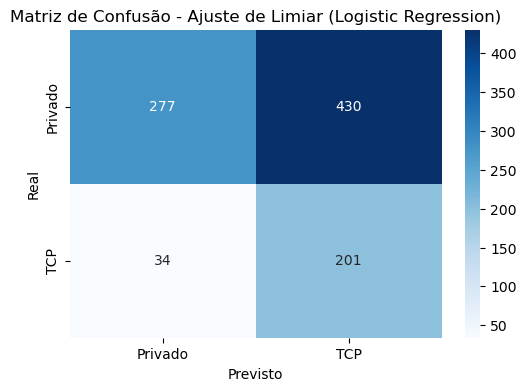

In [113]:
# Treine o modelo
best_model_m1.fit(x_train, y_train)

# Calcular probabilidades e encontrar o melhor limiar baseado no F1 Score
y_prob_train = best_model_m1.predict_proba(x_train)[:, 1]
precisions, recalls, thresholds = precision_recall_curve(y_train, y_prob_train)

best_threshold, best_f1 = max(((threshold, f1_score(y_train, (y_prob_train >= threshold).astype(int))) for threshold in thresholds), key=lambda x: x[1])

print(f"Melhor limiar: {best_threshold} com F1 Score: {best_f1}")

# Ajustar previsões no conjunto de teste
y_pred_adjusted = (best_model_m1.predict_proba(X=x_test)[:, 1] >= best_threshold).astype(int)

# Matriz de Confusão
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)

# Exibição da Matriz de Confusão
plt.figure(figsize=(6, 4))
sns.heatmap(cm_adjusted, annot=True, fmt='d', cmap='Blues', xticklabels=['Privado', 'TCP'], yticklabels=['Privado', 'TCP'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title(f'Matriz de Confusão - Ajuste de Limiar ({best_model_name})')
plt.show()

In [114]:
print("ROC AUC: ", roc_auc_score(y_test, y_pred_adjusted))
print("Precision: ", precision_score(y_test, y_pred_adjusted))
print("Accuracy: ", accuracy_score(y_test, y_pred_adjusted))
print("Recall: ", recall_score(y_test, y_pred_adjusted))
print("F1 Score: ", f1_score(y_test, y_pred_adjusted))

ROC AUC:  0.6235577357127811
Precision:  0.3185419968304279
Accuracy:  0.5074309978768577
Recall:  0.8553191489361702
F1 Score:  0.46420323325635104


In [100]:
# CORREÇÃO: Use o TreeExplainer e passe o objeto do modelo diretamente
explainer = shap.TreeExplainer(best_model_m1) 

# O cálculo dos valores SHAP agora funciona corretamente
shap_values = explainer.shap_values(x_test)

# Para visualizar a primeira predição
shap.initjs()

C:\Users\alefs\anaconda3\lib\site-packages\shap\plots\_beeswarm.py:950: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  pl.tight_layout()


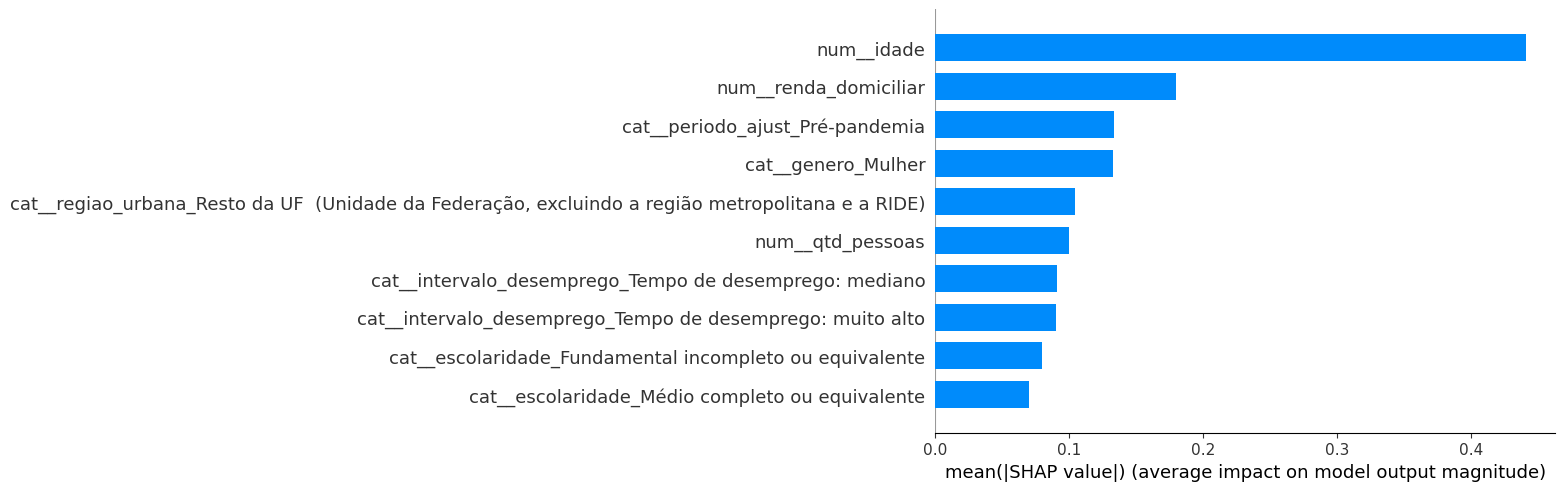

In [105]:
feature_names = preprocessor.get_feature_names_out()

shap.summary_plot(shap_values, features= x_test,
                  feature_names= feature_names,
                  plot_type="bar",
                 max_display = 10)

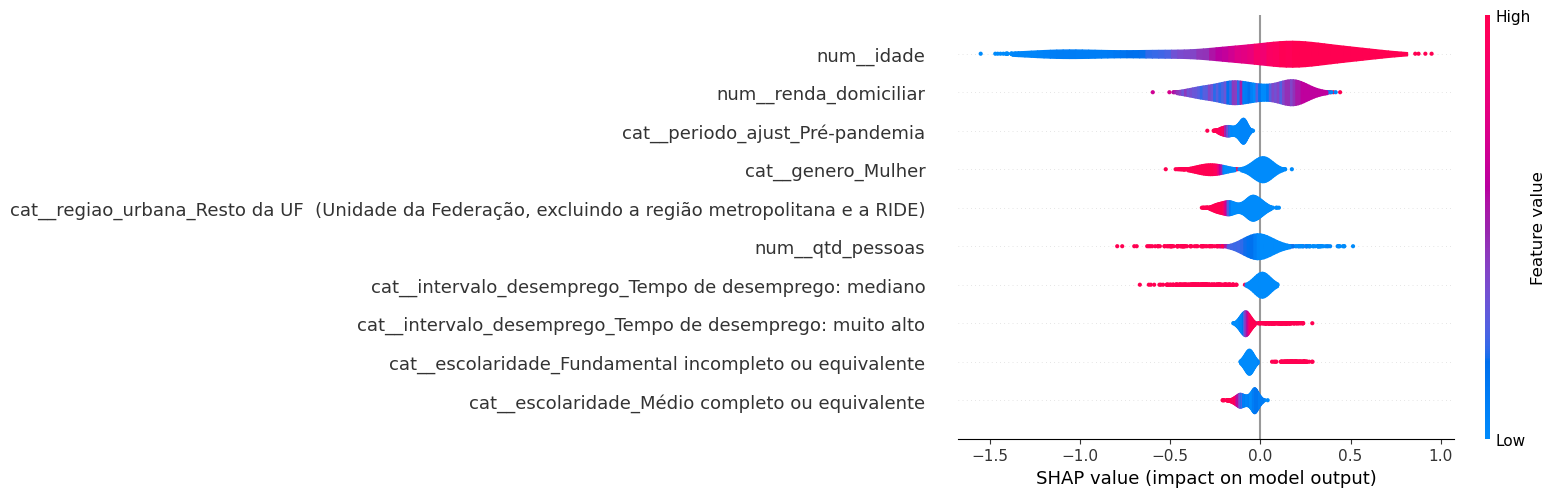

In [106]:
shap.summary_plot(shap_values, 
                  features=x_test.toarray(), # <--- A MUDANÇA PRINCIPAL ESTÁ AQUI
                  feature_names=feature_names,
                  plot_type="violin",
                  max_display=10)